# Relaxed Multivariate Bernoulli Distribution (RelaxedMVB)

In [45]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [46]:
class GaussianCopulaTriL(tfd.TransformedDistribution):
    """Takes a location, and lower triangular matrix for the Cholesky factor."""
    def __init__(self, loc, scale_tril):
        super().__init__(
        distribution=tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale_tril),
        bijector=tfb.NormalCDF(),
        validate_args=False,
        name="GaussianCopulaTriLUniform")

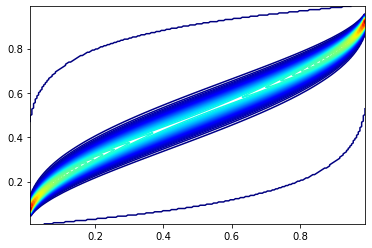

In [47]:
unit_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(unit_interval, unit_interval)
coordinates = np.concatenate(
    [x_grid[..., np.newaxis],
     y_grid[..., np.newaxis]], axis=-1)

pdf = GaussianCopulaTriL(
    loc=[0., 0.],
    scale_tril=[[1., 0.8], [0.6, 0.1]],
).prob(coordinates)

# Plot its density.
plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet);

In [4]:
class RelaxedMVB(tf.keras.layers.Layer):
    """Takes a location vector 'loc' and covariance matrix 'sigma' to create a Relaxed Multivariate Distribution (RelaxedMVB); 
    Wang et. al(2020): http://proceedings.mlr.press/v124/wang20b.html
    
    Args:
    loc: location vector
    sigma: covariance matrix
    
    """
    
    def __init__(self, dim:int, batch_size:int):
        super().__init__()
        self.dim = dim
        self.batch_size = batch_size
        
    
    def call(self, inputs):
        loc, sigma = inputs[..., 0], inputs[..., 1]
        assert loc.shape.as_list() == sigma.shape.as_list()
        normal_sample = tf.random.normal(mean=0., stddev=1.0, shape=((self.batch_size, self.dim, self.dim)))
        #chol_sigma = tf.linalg.cholesky(sigma)
        g = sigma * normal_sample
        normal_cdf = tfb.NormalCDF() #bijector
        u = normal_cdf.forward(g)
        l = tf.math.log(loc) + tf.math.log(u) + tf.math.log(1-u)
        return tf.nn.sigmoid(tf.expand_dims(l, -1))

In [7]:
import joblib
from models.MoNet import getMoNet

In [8]:
X_train_partial = joblib.load("./serialized/data/liver/x_train_full.lib")
y_train_partial = joblib.load("./serialized/data/liver/y_train_full.lib")
X_val = joblib.load("./serialized/data/liver/x_val_full.lib")
y_val = joblib.load("./serialized/data/liver/y_val_full.lib")
X_test = joblib.load("./serialized/data/liver/x_test_full.lib")
y_test = joblib.load("./serialized/data/liver/y_test_full.lib")
y_train_partial = y_train_partial.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

In [9]:
r = RelaxedMVB(256, 16)

In [15]:
s = y_val[:16, ..., None]
s = np.tile(s, 2)
s.shape

(16, 256, 256, 2)

In [17]:
out = r(s)

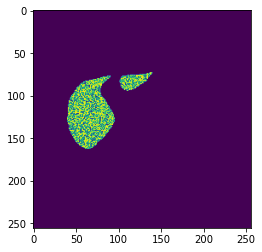

In [24]:
plt.imshow(out[15,..., 0])
plt.show()

In [25]:
import segmentation_models as sm
dice_l = sm.losses.bce_dice_loss
dice_c = sm.metrics.f1_score

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
negloglik_dice = lambda y, rv_y: -rv_y.log_prob(y) + dice_l(tf.cast(y, tf.float32), tf.cast(rv_y, tf.float32))

In [30]:
base_model = getMoNet(input_shape=(256, 256, 1), output_classes=2, output_activation='sigmoid')
model = tf.keras.Sequential([base_model, RelaxedMVB(256, 16)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 256, 256, 2)       403576    
_________________________________________________________________
relaxed_mvb_3 (RelaxedMVB)   (16, 256, 256, 1)         0         
Total params: 403,576
Trainable params: 401,684
Non-trainable params: 1,892
_________________________________________________________________


In [31]:
model.compile(loss=dice_l, optimizer='adam', 
                   metrics=[dice_c,
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Accuracy()
                           ])

In [53]:
model.fit(X_train_partial[..., None], y_train_partial[..., None],
              validation_data=(X_val[..., None], y_val[..., None]),
              epochs=5,
              batch_size=16)

Epoch 1/5
324/324 [==============================] - 63s 194ms/step - loss: 0.9714 - f1-score: 0.2230 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.9651 - val_f1-score: 0.2365 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
324/324 [==============================] - 63s 194ms/step - loss: 0.9349 - f1-score: 0.2452 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.9314 - val_f1-score: 0.2578 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
324/324 [==============================] - 63s 195ms/step - loss: 0.9067 - f1-score: 0.2635 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.9150 - val_f1-score: 0.2697 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
324/324 [==============================] - 63s 195ms/step - loss: 0.8865 - f1-score: 0.277

In [33]:
y_pred = model.predict(X_test[..., None], batch_size=16)

In [54]:
t = [model(X_test[16:32, ..., None]) for _ in range(30)]
t = np.stack(t)
t.shape

(30, 16, 256, 256, 1)

In [55]:
t_mean = np.mean(t, axis=0)
t_std = np.mean(t, axis=1)

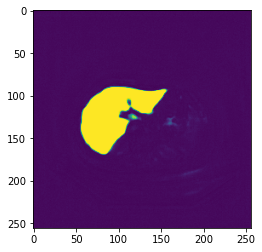

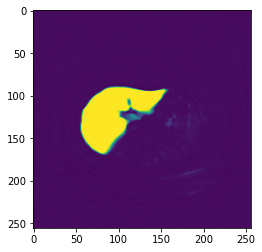

In [56]:
i = 10
plt.imshow(t_mean[i, ..., 0])
plt.show()
plt.imshow(t_std[i, ..., 0])